# Eigen mode decomposition: 

Katie Brennan  
started August 2021  
  
#### Goals: 


In [1]:
import sys,os
import xarray as xr
import numpy as np
import scipy as spy
import pickle 

import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from collections import OrderedDict 

import time as timestamp 

In [2]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")
import LIM_utils as lim

import LIM_utils_kb as limkb
import LIM_stats_kb as statskb
import LIM_plot_kb as plotkb
import LIM_building as limbuild

In [15]:
import importlib
importlib.reload(limkb)
importlib.reload(statskb)
importlib.reload(limbuild)

<module 'LIM_building' from '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_building.py'>

In [4]:
# %load_ext autoreload
# %autoreload 2

In [5]:
arc_proj = dict(projection=ccrs.Stereographic(central_latitude=90,
                                              central_longitude=-45,
                                              true_scale_latitude=0.1))
proj = dict(projection=ccrs.Robinson(central_longitude=0.),zorder=1)

In [6]:
month_names = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']

In [7]:
# number of EOFs to retain for the LIM state vector
ntrunc = 30 # EOF truncation for individual fields (reduced-state space)
nmodes = 30 # number of coupled EOFs for LIM state space (truncated-state space)
# ntrunc = 50
# nmodes = 50
#nmodes = 25
nmodes_sic = 50
#modes_sic = 20

mo='all'
#mo=0

# forecast lead time in months that defines the LIM training
tau = 1

# training data defined by the first ntrain times
# fraction of years used in training
# ensures that start year of both train and validation data is january 
ntrain = 1
ntraintimes = 1872
#nttrain_valid = 1
ntrain_valid = 0.3
#nvalidtimes = 1872, 
nvalidtimes = 3600

# variables to include in the LIM (note "vars" is a Python command)
#limvars = ['tas','zg']
#limvars = ['tas','rlut','zg']
# limvars = ['sic']
#limvars = ['tas','sic']
#limvars = ['tas','sic','zg','psl','pr','tos']
#limvars = ['tas','psl','tos','sit','sic']
# limvars = ['tas','tos','psl','sit','sic']
# limvars_nosic = ['tas','tos','psl','sit']
#limvars = ['tas','tos','psl','sit','sic']
limvars = ['tas','tos','sit','sic']
limvars_nosic = ['tas','tos','sit']
#limvars_nosic = []
nvars = len(limvars)

# specify the model source 
# train_dsource = 'ccsm4_hist_kb'
# train_dsource = 'mpi_hist_kb'
train_dsource = 'cmip6_mpi_hist'
valid_dsource = 'mpi_lm_kb'
# valid_dsource = 'mpi_lm_kb'
# valid_dsource = 'ccsm4_lm_kb'

sic_separate = True
#sic_separate = False
Insamp = False

In [8]:
from datetime import date

today = date.today()

#Year-month-day
today_date = today.strftime("%Y%m%d")

In [9]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
pi = np.pi

# fill continents if plotting SST; otherwise no
# if var_to_extract == 'tos':
#     noland = True
# else:
#     noland = False

infile_20cr_tas = '/home/disk/kalman3/rtardif/LMR/data/model/20cr/tas_sfc_Amon_20CR_185101-201112.nc'

fdic_train = limkb.build_training_dic(train_dsource)
fdic_valid = limkb.build_training_dic(valid_dsource)

full_names, areawt_name, month_names = limbuild.load_full_names()
areacell, areacell_dict = limbuild.load_areacell_dict(fdic_train, remove_climo=False, 
                                                      detrend=False, verbose=False )

Loading from areacella_fx_MPI-ESM1-2-LR_historical_r1i1p1f1_gn.nc
Loading from reacello_Ofx_MPI-ESM1-2-LR_historical_r1i1p1f1_gn.nc


## Build L from scratch: 

### Load pre-truncated training data: 

In [30]:
## Start with full training data: 
# [Ptrunc, Ptrunc_valid, E3, tot_var, 
#  tot_var_eig, W_all,standard_factor, nyears_train, 
#  var_dict] = limbuild.load_training_valid_data_full(limvars, fdic_train, mo, areacell, ntrain, 
#                                                     areawt_name, ntrunc, nmodes_sic, 
#                                                     sic_separate=sic_separate,
#                                                     remove_climo=True,detrend=True, 
#                                                     wt=True, verbose=True)

#limvars = ['tas', 'tos','sit','sic']
#limvars = ['sic']

# Start with truncated training data: 
#mod_folder = 'truncated_model_data/last_millennium/'
mod_folder = 'truncated_model_data/'
#mod_filename = '_ntrunc30_mpi_lm_kb_20210503.pkl'
#mod_filename = '_ntrunc30_monthall_ccsm4_hist_kb_20210507_ntrain1_standtest.pkl'
mod_filename = '_ntrunc30_monthall_mpi_hist_kb_20210507_ntrain1_standtest.pkl'
#mod_filename = '_ntrunc30_mpi_lm_kb_20210507_ntrain0_3_standtest.pkl'
#mod_sic_filename = '_ntrunc50_mpi_lm_kb_20210406.pkl'
#mod_sic_filename = '_ntrunc50_monthall_ccsm4_hist_kb_20210507_ntrain1_standtest.pkl'
mod_sic_filename = '_ntrunc50_monthall_mpi_hist_kb_20210507_ntrain1_standtest.pkl'
#mod_sic_filename = '_ntrunc50_month0_mpi_hist_kb_20210727_ntrain1_standtest.pkl'
#mod_sic_filename = '_ntrunc50_mpi_lm_kb_20210507_ntrain0_3_standtest.pkl'

[Ptrunc, _, E3, tot_var, 
 tot_var_eig, W_all, standard_factor, 
 nyears_train, var_dict] = limbuild.load_training_data_truncated(limvars, mod_folder, mod_sic_filename, 
                                                                 mod_filename, mo,1,ind_month_trunc=True)

var_dict = limbuild.get_var_indices(limvars, var_dict)

Loading truncated tas
Loading truncated tos
Loading truncated sit
Loading truncated sic
working on tas
working on tos
working on sit
working on sic


In [31]:
W_all['tas'].shape, W_all['tos'].shape, W_all['sic'].shape

((18432,), (56320,), (56320,))

In [33]:
 np.sum(np.var(Ptrunc['sic'],axis=1)),np.sum(np.var(Ptrunc['tas'],axis=1)), np.sum(np.var(Ptrunc['tos'],axis=1)),np.sum(np.var(Ptrunc['sit'],axis=1))

(1.0, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002)

In [34]:
var = 'sic'
if var == 'sic': 
    mod_fname = mod_sic_filename
else: 
    mod_fname = mod_filename

[X_var, v, E3[var], standard_factor[var], 
 W_all[var]] = limkb.load_truncated_data(var, mod_folder, mod_fname)

Loading truncated sic


In [35]:
# ntime = X_var.shape[1]
# nyears_train = int((ntime*ntrain)/12)
# nyears_valid = int((ntime*(1-ntrain))/12)

# X_t = np.reshape(X_var,(X_var.shape[0],int(ntime/12),12))

# X_train = X_t[:,0:nyears_train,mo:mo+2]
# X_train_2d = np.reshape(X_train,(X_train.shape[0],nyears_train*2))
# X_valid = X_t[:,nyears_train:,mo]

In [36]:
nyears_valid, nyears_train, X_t.shape, X_train.shape, X_train_2d.shape, X_valid.shape

NameError: name 'nyears_valid' is not defined

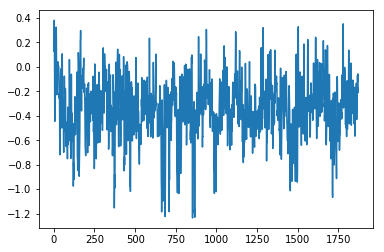

In [37]:
# plt.plot(Ptrunc['tas'][0,:])
# plt.plot(Ptrunc['tos'][0,:])
plt.plot(Ptrunc['sic'][0,:])

In [38]:
ndof_all = limkb.count_ndof_all(limvars, E3, sic_separate=sic_separate)

[Ptrunc_all, E3_all, 
Ptrunc_sic,E_sic] = limkb.stack_variable_eofs(limvars, ndof_all, ntrunc, Ptrunc, E3, 
                                              var_dict, sic_separate=sic_separate)

P_train = np.concatenate((Ptrunc_all, Ptrunc_sic),axis=0)


# [P_train, Fvar, E] = limkb.step2_multivariate_compress(Ptrunc_all, nmodes, E3_all, Ptrunc_sic, 
#                                                        sic_separate=sic_separate, Trunc_truth=False)

# [Ptrunc_all, E3_all] = limkb.stack_variable_eofs(limvars, ndof_all, ntrunc, Ptrunc, E3, 
#                                                  var_dict, sic_separate=sic_separate)

# [P_train, Fvar, E] = limkb.step2_multivariate_compress(Ptrunc_all,nmodes, E3_all, 0, 
#                                                        sic_separate=sic_separate, Trunc_truth=False)

0, tas
1, tos
2, sit


In [39]:
# P_train = Ptrunc['sic']
# nmo = int(P_train.shape[1]/nyears_train)
# nmo, nyears_train

## Train LIM: 

In [63]:
tau

1

In [313]:
nmo = int(P_train.shape[1]/nyears_train)
# nmo = 2
P_train_3d = np.reshape(P_train, (P_train.shape[0],nyears_train,nmo))

if mo is 'all':
    LIMd2, G2 = lim.LIM_train(tau,P_train)
    print('Training LIM with tau = '+str(tau))
else: 
    LIMd2, G2 = lim.LIM_train_flex(tau,P_train_3d[:,:,0], P_train_3d[:,:,1])
    print('Training LIM with tau = '+str(tau))

Training LIM with tau = 1


In [314]:
max_eigenval = np.real(LIMd2['lam_L']).max()

if max_eigenval >0: 
    LIMd2['lam_L_adj'] = LIMd2['lam_L'] - (max_eigenval+0.01)
else: 
    LIMd2['lam_L_adj'] = LIMd2['lam_L']

#### Any positive eigenvalues in L?

In [315]:
(LIMd2['lam_L']>0).sum()/(LIMd2['lam_L'].shape[0])

0.0

In [300]:
G = LIMd2['Gt']
L = np.log(G)/t

In [306]:
G

array([[ 3.88599554e-01, -4.05322824e-02, -2.15591205e-02, ...,
         5.26199835e-02, -5.41162193e-02,  3.57220070e-02],
       [-1.43791218e-01,  2.62374207e-01,  9.41821281e-03, ...,
        -1.15270987e-01,  5.67084868e-02, -1.68944131e-02],
       [-7.82979372e-02,  1.89875216e-02,  2.40993698e-01, ...,
         8.75435330e-03, -9.55924125e-02,  2.10639196e-02],
       ...,
       [-3.60774906e-02, -1.84343616e-02, -6.59307660e-03, ...,
         3.75409898e-01, -7.12201211e-03,  2.50340585e-02],
       [ 2.25926698e-02,  2.46775515e-04, -2.94394142e-04, ...,
         1.63595338e-02,  4.88844361e-01, -5.39689726e-02],
       [-2.51791525e-02, -1.34890940e-02,  1.45090971e-02, ...,
        -2.22479349e-02, -5.68446528e-02,  4.10481314e-01]])

In [304]:
Lt

array([[-1.64193763e-02-1.89659023e-02j, -3.64659884e-03+1.19768719e-02j,
        -1.13804737e-04+4.72760644e-04j, ...,
        -6.02938760e-02+2.18131725e-02j, -2.99568729e-02-1.34205976e-02j,
        -6.21827019e-03-3.95283709e-02j],
       [ 1.88813187e-02+1.07131598e-01j,  4.69234970e-02-1.02953592e-01j,
         5.30089292e-04+1.08330338e-03j, ...,
        -2.07162000e-02+2.57748854e-02j,  6.96295204e-02-4.60642883e-02j,
         8.72116139e-02+1.08628554e-03j],
       [-3.13153619e-02-4.41315977e-02j, -1.06782425e-02-6.64616996e-02j,
         2.84413208e-04+1.15362778e-03j, ...,
        -8.65638439e-04+1.46011519e-02j, -1.63450349e-01-2.56329231e-02j,
        -1.34981705e-01-5.54138925e-02j],
       ...,
       [-7.10774801e-03+2.55649180e-03j,  6.23218599e-03-1.85133706e-02j,
        -6.76155001e-05+9.45563235e-05j, ...,
         5.82184511e-02+8.99164961e-03j,  1.58867128e-02+1.48298288e-03j,
         6.64899263e-03+7.83741926e-03j],
       [-1.95824490e-03+1.16262370e-02j,  2.

In [302]:
Gt = np.matmul(np.matmul(LIMd2['vec'],np.diag(np.exp(LIMd2['lam_L']*t))),LIMd2['veci'])
Lt = np.matmul(np.matmul(LIMd2['vec'],np.diag(LIMd2['lam_L'])),LIMd2['veci'])

In [305]:
Lt

array([[-1.64193763e-02-1.89659023e-02j, -3.64659884e-03+1.19768719e-02j,
        -1.13804737e-04+4.72760644e-04j, ...,
        -6.02938760e-02+2.18131725e-02j, -2.99568729e-02-1.34205976e-02j,
        -6.21827019e-03-3.95283709e-02j],
       [ 1.88813187e-02+1.07131598e-01j,  4.69234970e-02-1.02953592e-01j,
         5.30089292e-04+1.08330338e-03j, ...,
        -2.07162000e-02+2.57748854e-02j,  6.96295204e-02-4.60642883e-02j,
         8.72116139e-02+1.08628554e-03j],
       [-3.13153619e-02-4.41315977e-02j, -1.06782425e-02-6.64616996e-02j,
         2.84413208e-04+1.15362778e-03j, ...,
        -8.65638439e-04+1.46011519e-02j, -1.63450349e-01-2.56329231e-02j,
        -1.34981705e-01-5.54138925e-02j],
       ...,
       [-7.10774801e-03+2.55649180e-03j,  6.23218599e-03-1.85133706e-02j,
        -6.76155001e-05+9.45563235e-05j, ...,
         5.82184511e-02+8.99164961e-03j,  1.58867128e-02+1.48298288e-03j,
         6.64899263e-03+7.83741926e-03j],
       [-1.95824490e-03+1.16262370e-02j,  2.

## Empirical Normal Modes: 

### $\alpha$ and $\omega$ (Re and Im parts of eigenvalues): 

In [316]:
alpha = np.real(LIMd2['lam_L'])
omega = np.imag(LIMd2['lam_L'])

In [317]:
period = 2*pi/(omega)
decay_times = -1/alpha

| Mode | Decay time<br>(months) | Period<br>(months) | bTb | Growth Index |
| :-: | :-: | :-: | :-: | :-: | 
| 43 | 441.76 | $\infty$ |
| 53 | 28.72 | $\infty$ |
| 71/72 | 14.89 | 130.99 |
| 62/63 | 14.71 | 67.43 |
| 80 | 12.54 | $\infty$ |
| 81 | 11.55 | $\infty$ |
| 84/85 | 10.47 | 299.65 |
| 92 | 7.66 | $\infty$ |
| 106/107 | 6.55 | 334.08 |

In [381]:
n = 12
decay_times[np.flip(np.argsort(decay_times))][n], period[np.flip(np.argsort(decay_times))][n], np.flip(np.argsort(decay_times))[n]

(6.554160289335453, -334.0812718339641, 107)

In [193]:
P = alpha**t*(np.cos(omega*t)*np.real(LIMd2['vec'])-np.sin(omega*t)*np.imag(LIMd2['vec']))

In [58]:
# t =1

# Gt = np.matmul(np.matmul(LIMd2['vec'],np.diag(np.exp(LIMd2['lam_L_adj']*t))),LIMd2['veci'])
# L = np.log(Gt)/t

# val,vec = np.linalg.eig(L)
# veci = np.linalg.inv(vec)
# lam_L = np.log(val)/tau

# Ldict = {}
# Ldict['vec'] = vec
# Ldict['veci'] = veci
# Ldict['val'] = val
# Ldict['lam_L'] = lam_L
# Ldict['L']= L

In [70]:
Ldict['vec'].shape, nmodes, nmodes_sic, E3_all.shape[1], E3_all.shape

((140, 140), 30, 50, 90, (131072, 90))

### Plotting a & b (Re and Im parts of eigenvectors): 

In [243]:
nmodes = E3_all.shape[1]

L_vec_decomp = limkb.decompress_eof_separate_sic(LIMd2['vec'],nmodes,nmodes_sic,
                                                 E3_all,E_sic,limvars,var_dict,
                                                 W_all,Weights=True,sic_separate=sic_separate)

In [244]:
L_vec_decomp_var  = {}
start = 0
size = 0

for i,var in enumerate(limvars):
    print('Working on ...'+var)
    size = E3[var].shape[0]
    hold = L_vec_decomp[start:start+size,:]
    print(hold.shape)
    if len(var_dict[var]['lat'].shape)>1:
        la = var_dict[var]['lat'].shape[0]
        lo = var_dict[var]['lon'].shape[1]
    else:
        la = var_dict[var]['lat'].shape[0]
        lo = var_dict[var]['lon'].shape[0]
    print('shape: '+str(la)+', '+str(lo))
    L_vec_decomp_var[var] = np.reshape(hold,(la,lo,140))
    
    start = start+size

Working on ...tas
(18432, 140)
shape: 96, 192
Working on ...tos
(56320, 140)
shape: 220, 256
Working on ...sit
(56320, 140)
shape: 220, 256
Working on ...sic
(56320, 140)
shape: 220, 256


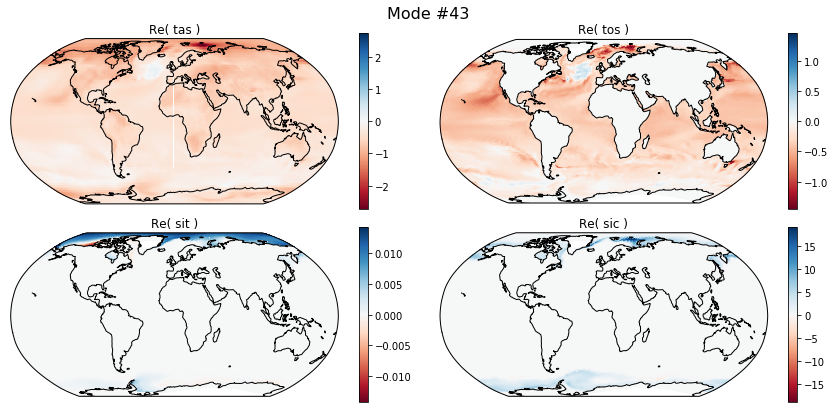

In [382]:
fig, axs = plt.subplots(2,2,figsize=(12,6),subplot_kw={'projection': ccrs.Robinson()})
ax = axs.flatten()
mode = 43

for i,var in enumerate(limvars):
    m = np.max(np.abs(np.real(L_vec_decomp_var[var][:,:,mode])))
    cf = ax[i].pcolormesh(var_dict[var]['lon'],var_dict[var]['lat'],
                          np.real(L_vec_decomp_var[var][:,:,mode]),cmap='RdBu', 
                          transform=ccrs.PlateCarree(),vmin=-m,vmax=m)
    ax[i].set_title('Re( '+var+' )')
    ax[i].coastlines()
    
    fig.colorbar(cf, ax=ax[i])
    
plt.suptitle('Mode #'+str(mode), fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

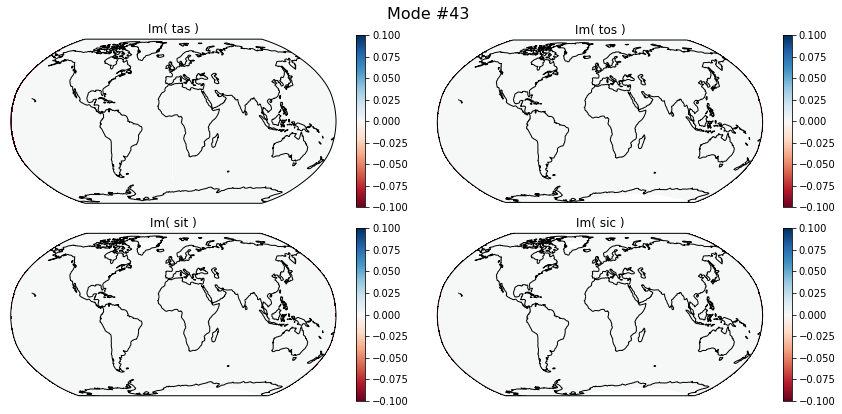

In [383]:
fig, axs = plt.subplots(2,2,figsize=(12,6),subplot_kw={'projection': ccrs.Robinson()})
ax = axs.flatten()

for i,var in enumerate(limvars):
    m = np.max(np.abs(np.imag(L_vec_decomp_var[var][:,:,mode])))
    cf = ax[i].pcolormesh(var_dict[var]['lon'],var_dict[var]['lat'],
                          np.imag(L_vec_decomp_var[var][:,:,mode]),cmap='RdBu', 
                          transform=ccrs.PlateCarree(),vmin=-m,vmax=m)
    ax[i].set_title('Im( '+var+' )')
    ax[i].coastlines()
    
    fig.colorbar(cf, ax=ax[i])
    
plt.suptitle('Mode #'+str(mode), fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

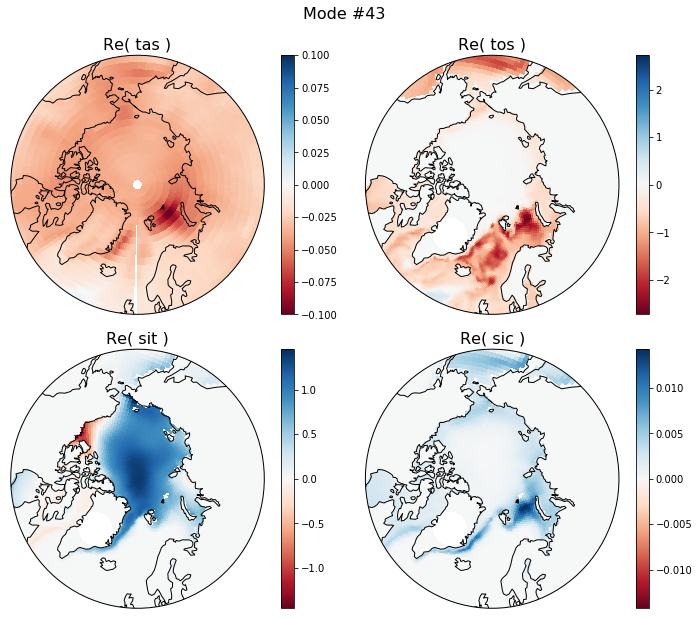

In [384]:
import matplotlib.path as mpath
fig, axs = plt.subplots(2,2,figsize=(10,9),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()
fig.subplots_adjust(bottom=0.05, top=0.95,
                        left=0.04, right=0.95, wspace=0.02)

for i,var in enumerate(limvars):
    ax[i].set_title('Re( '+var+' )', fontsize=16)
    ax[i].coastlines()
    fig.colorbar(cf, ax=ax[i])
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax[i].set_boundary(circle, transform=ax[i].transAxes)
    ax[i].set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
    
    m = np.max(np.abs(np.real(L_vec_decomp_var[var][:,:,mode])))
    cf = ax[i].pcolormesh(var_dict[var]['lon'],var_dict[var]['lat'],
                          np.real(L_vec_decomp_var[var][:,:,mode]),cmap='RdBu', 
                          transform=ccrs.PlateCarree(),vmin=-m,vmax=m)
    
plt.suptitle('Mode #'+str(mode), fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

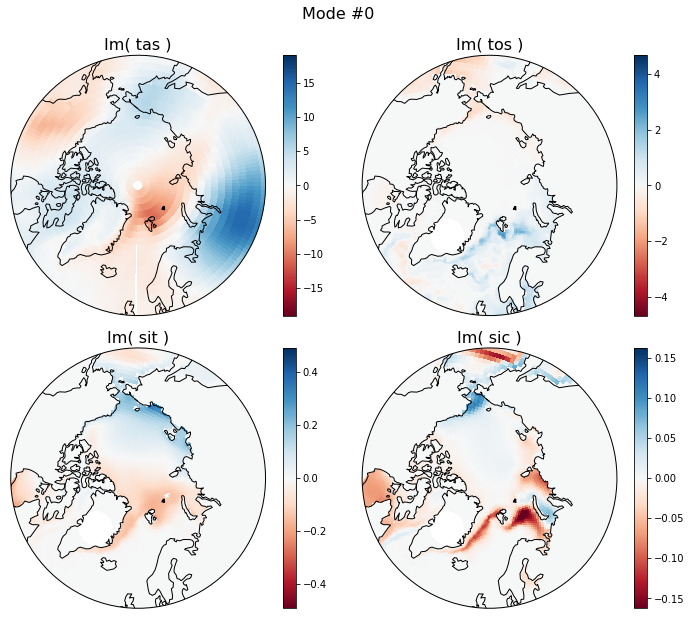

In [385]:
import matplotlib.path as mpath
fig, axs = plt.subplots(2,2,figsize=(10,9),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()
fig.subplots_adjust(bottom=0.05, top=0.95,
                        left=0.04, right=0.95, wspace=0.02)
# mode = 0

for i,var in enumerate(limvars):
    ax[i].set_title('Im( '+var+' )', fontsize=16)
    ax[i].coastlines()
    fig.colorbar(cf, ax=ax[i])
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax[i].set_boundary(circle, transform=ax[i].transAxes)
    ax[i].set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
    
    m = np.max(np.abs(np.real(L_vec_decomp_var[var][:,:,mode])))
    cf = ax[i].pcolormesh(var_dict[var]['lon'],var_dict[var]['lat'],
                          np.imag(L_vec_decomp_var[var][:,:,mode]),cmap='RdBu', 
                          transform=ccrs.PlateCarree(),vmin=-m,vmax=m)
    
plt.suptitle('Mode #'+str(mode), fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

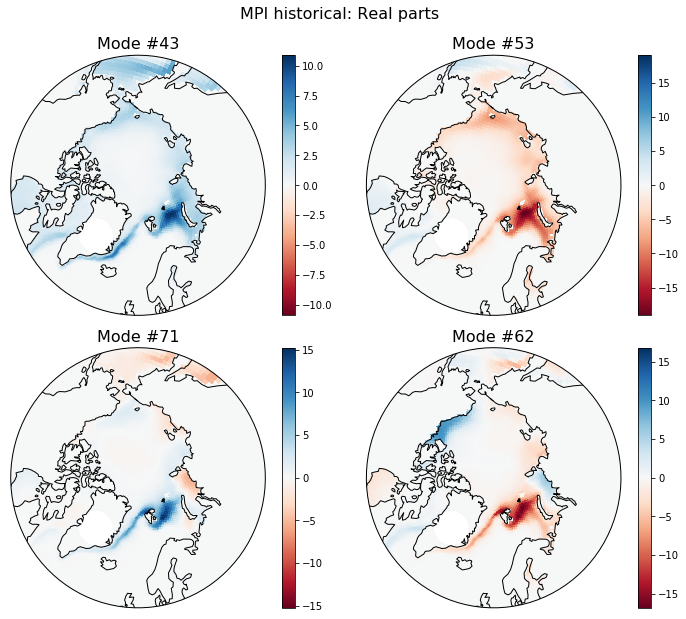

In [387]:
modes = [43,53,71,62]
var = 'sic'

fig, axs = plt.subplots(2,2,figsize=(10,9),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()
fig.subplots_adjust(bottom=0.05, top=0.95,
                        left=0.04, right=0.95, wspace=0.02)

for i,mode in enumerate(modes):
    ax[i].set_title('Mode #'+str(mode), fontsize=16)
    ax[i].coastlines()
    fig.colorbar(cf, ax=ax[i])
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax[i].set_boundary(circle, transform=ax[i].transAxes)
    ax[i].set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
    
    m = np.max(np.abs(np.real(L_vec_decomp_var[var][:,:,mode])))
    cf = ax[i].pcolormesh(var_dict[var]['lon'],var_dict[var]['lat'],
                          np.real(L_vec_decomp_var[var][:,:,mode]),cmap='RdBu', 
                          transform=ccrs.PlateCarree(),vmin=-m,vmax=m)
    
plt.suptitle('MPI historical: Real parts', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])